# Interactive tutorial: *the membrane potential in action*

## Objectives
- To develop an electrical engineer's perspective of the neuronal membrane and its dynamics (Hodgkin-Huxley model)
- To understand the different membrane components involved in the generation of action potentials
- To develop an intuition of how action potentials are sensed by extracellular recording devices

*Side objective*: to illustrate the power of physical laws and computational models to help understand neural processes.

## Imports

In [1]:
%matplotlib notebook
from numpy import exp
from utils import initialize_model, interactive_simulation

## Model construction

We are going to construct a pyramidal regular spiking neuron model as defined in [Pospischil et al. 2008](https://link.springer.com/article/10.1007/s00422-008-0263-8). This type of neuron constitutes the primary type of excitatory neurons in the mammalian neocortex.

To better understand the involvement of the different membrane componentns in resulting membrane dynamics, we will construct this model step by step, one component at a time.

At each stage, we will evaluate the model's behavior by observing its response to an applied electrical stimulus $I_{stim}$, mimicking the impact of synaptic input or artificial stimulation.   

### Step 0: a cell membrane

Let's start with the simplest possible model configuration: a "naked" cell membrane (i.e. without ion channels). This simplistic membrane can be represented electrically by a capacitor $C_m$, enforcing a potential difference $V_m = V_{in} - V_{out}$ between the intracellular and extracellular space, known as the ***membrane potential***. You can see below the equivalent electrical circuit of this representation:

    TODO: PICTURE

As we apply an stimulating current, the membrane potential will change according to the following governing equation:

$C_m \frac{dV_m}{dt} = I_{stim}$

 02/02/2022 16:52:53: simulating model with CurrentPulseTrain(I=0.00uA/cm2, tpulse=30.0ms, npulses=1, PRF=0.10kHz, tstart=5.0ms) stimulus for 60.0 ms...


<IPython.core.display.Javascript object>


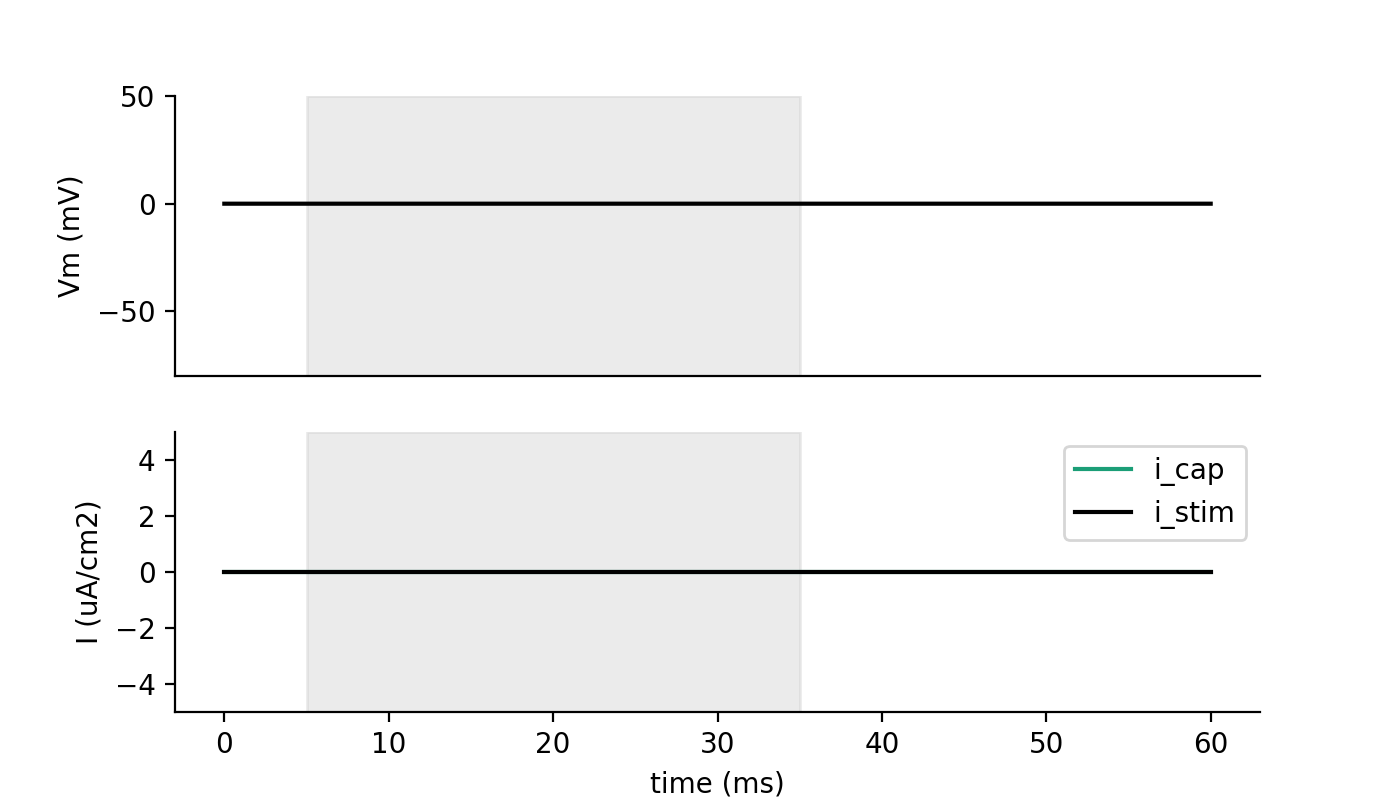

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='I', max=60.0, min=-15.0, st…

In [3]:
# Membrane capacitance (uF/cm2)
Cm = 1.0

# Create model and run interactive simulation
model = initialize_model(Cm=Cm)
interactive_simulation(model.copy());

#### Questions
- *Try varying the input current and look at the evolution of the membrane potential: what do you observe?*

### Step 1: a passive current

Let's start further constructing our neuron by adding a first passive membrane current term, called the ***non-specific leakage current*** ($I_{Leak}$). Our equivalent electrical circuit now is:

    TODO PICTURE

And the system's governing equation becomes:

$C_m \frac{dV_m}{dt} = I_{stim} - I_{Leak}(V_m)$

 02/02/2022 16:52:53: simulating model with CurrentPulseTrain(I=0.00uA/cm2, tpulse=30.0ms, npulses=1, PRF=0.10kHz, tstart=5.0ms) stimulus for 60.0 ms...


<IPython.core.display.Javascript object>


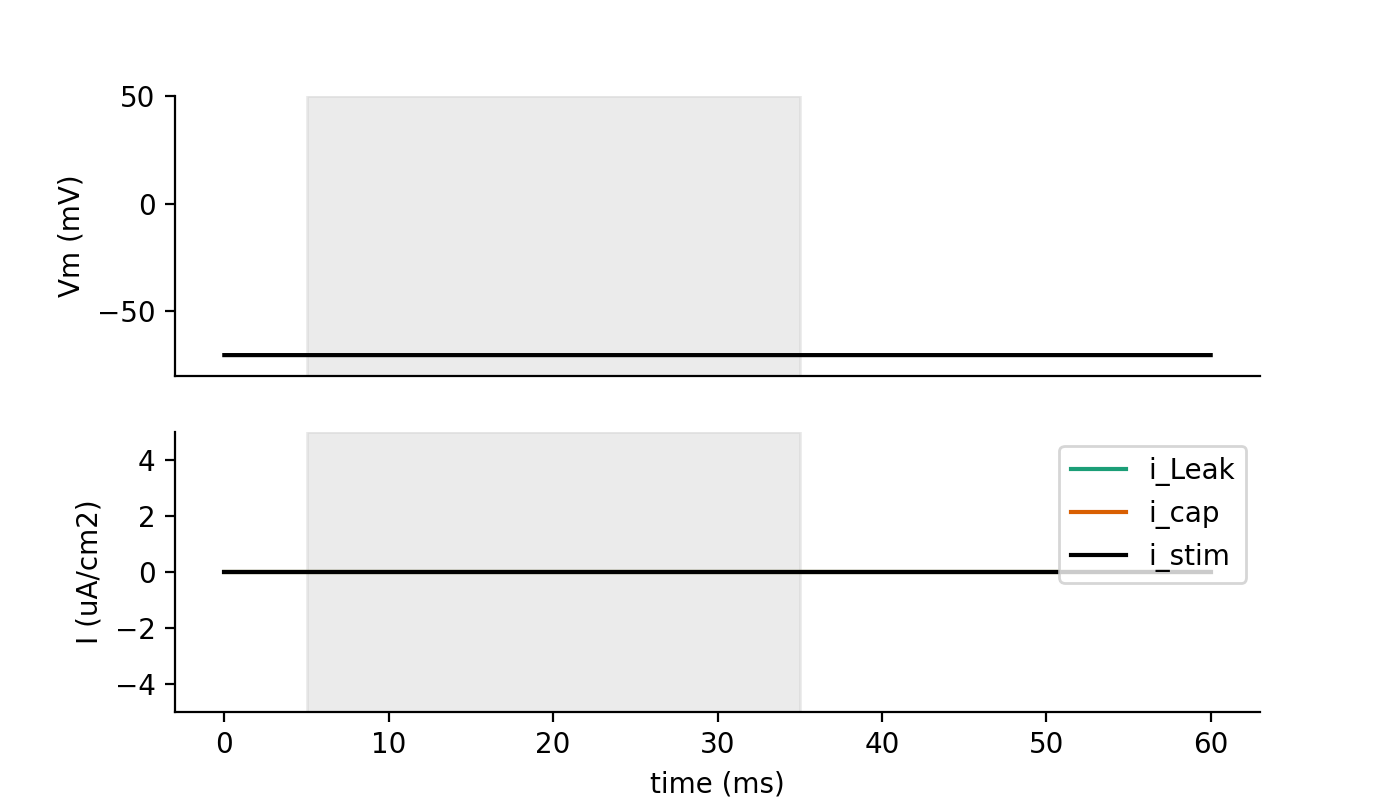

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='I', max=60.0, min=-15.0, st…

In [4]:
ELeak = -70.3   # Reversal potential (mV)
gLeak = 0.0205  # Maximal channel conductance (S/cm2)

def i_Leak(Vm):
    return gLeak * (Vm - ELeak)  # uA/cm2

# Update model and run interactive simulation
model.add_current(i_Leak)
interactive_simulation(model.copy());

#### Questions
- *In the absence of stimulus (I = 0), what can you tell about the effect of this current on the membrane?*
- *As you vary the stimulus amplitude, which differences in voltage variations do you observe?*
- *What do you conclude about the role of the leakage current on membrane potential?*

### Step 2: a voltage-gated sodium current

Our neuron membrane so far only exhibits passive responses to inputs, which is rather trivial. To obtain a nonlinear behavior, let's now add an active ***sodium current*** term ($I_{Na}$) representing voltage-gated sodium channels. Upon opening, theses channels trigger the entry of sodium ions inside the cell, following their concentration gradient.

Such channels are typically composed of voltage-densitive subunits, called *gates*, that each switch between closed and open states at specific rates $\alpha$ abd $\beta$ upon variation of the membrane potential. This process is captured by a kinetic scheme:

$\alpha(V_m): C -> O$  (opening)

$\beta(V_m): O -> C$   (closing)

For now, let us start implementing a sodium channel composed of 3 subunits of the same *M*-gate, which together regulate the channel conductance.

Our equivalent electrical circuit now is:

    TODO PICTURE

And the system's governing equation becomes:

$C_m \frac{dV_m}{dt} = I_{stim} - [I_{Leak}(V_m) + I_{Na}(m, V_m)]$

 02/02/2022 16:52:54: simulating model with CurrentPulseTrain(I=0.00uA/cm2, tpulse=30.0ms, npulses=1, PRF=0.10kHz, tstart=5.0ms) stimulus for 60.0 ms...


<IPython.core.display.Javascript object>


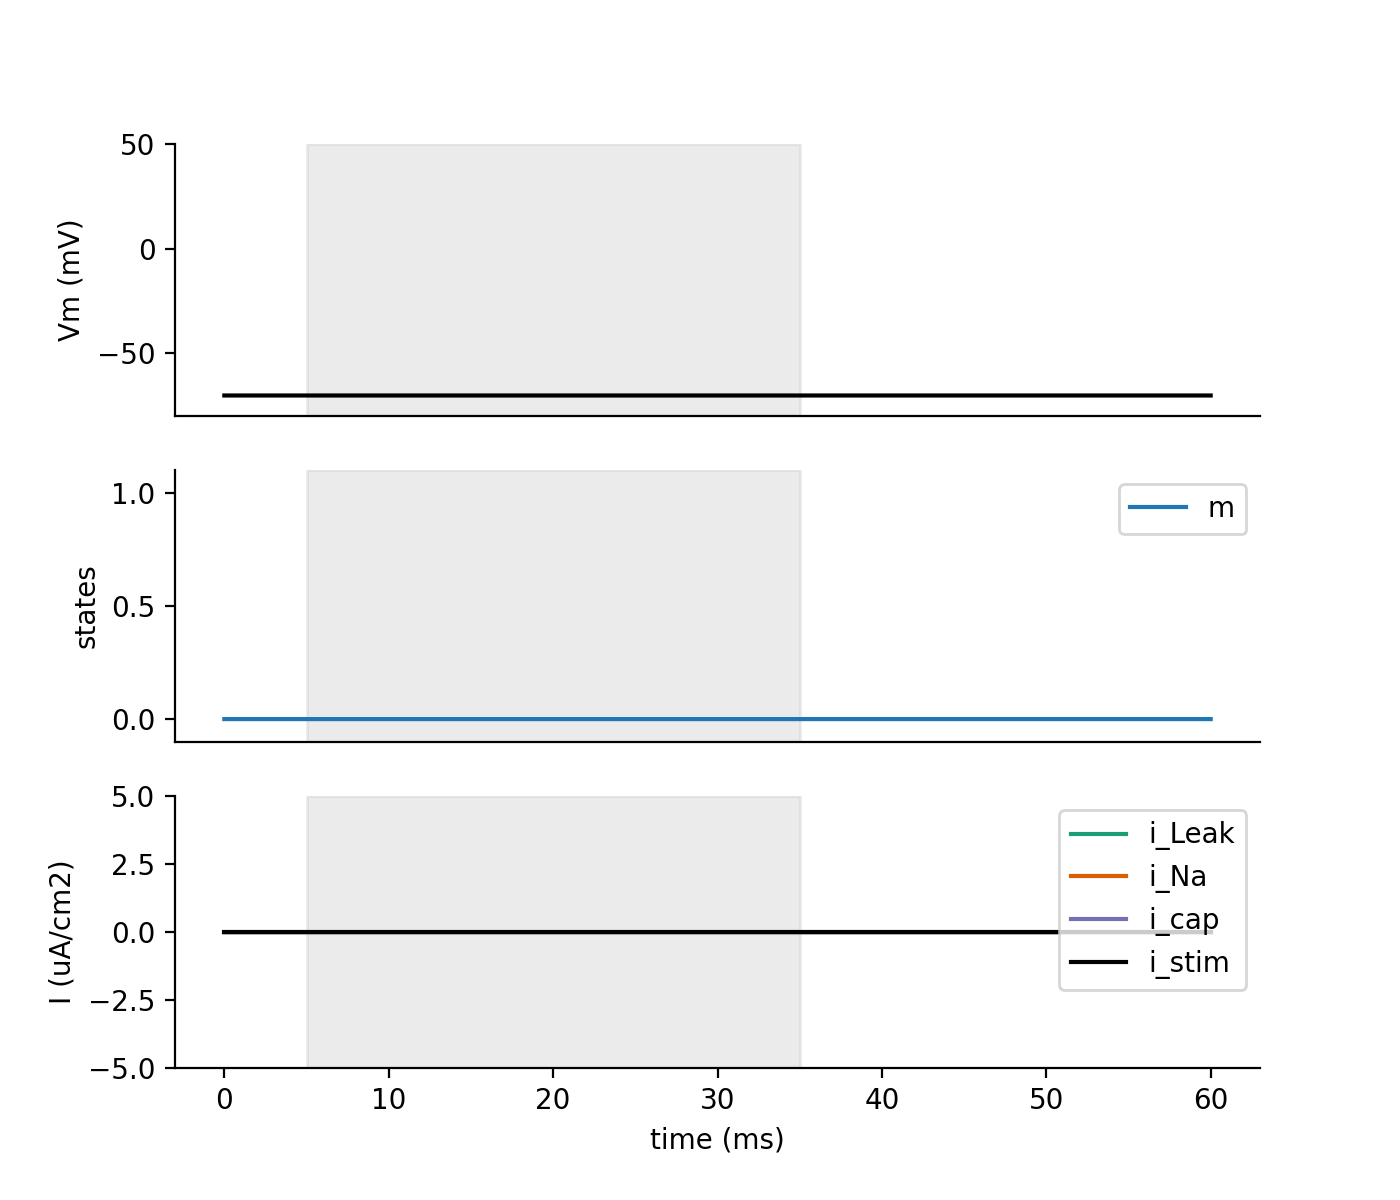

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='I', max=60.0, min=-15.0, st…

In [5]:
ENa = 50.0      # Reversal potential (mV)
gNa_bar = 56.0  # Maximal channel conductance (S/cm2)
V_T = -56.2     # Spike threshold adjustment parameter (mV)

def vtrap(x, y):
    ''' Generic function used to compute rate constants. '''
    return x / (exp(x / y) - 1)

def alpha_m(Vm):
    return 0.32 * vtrap(13 - (Vm - V_T), 4)  # ms-1

def beta_m(Vm):
    return 0.28 * vtrap((Vm - V_T) - 40, 5)  # ms-1

def dm_dt(m, Vm):
    return alpha_m(Vm) * (1 - m) - beta_m(Vm) * m  # ms-1

def m_inf(Vm):
    return alpha_m(Vm) / (alpha_m(Vm) + beta_m(Vm))  # (-)

def i_Na(m, Vm):
    return gNa_bar * m**3 * (Vm - ENa)  # uA/cm2

# Update model and run interactive simulation
model.add_current(i_Na)
model.add_state(dm_dt, m_inf)
interactive_simulation(model.copy());

#### Questions
- *For zero or negative stimulus (I <= 0), do you observe any difference in behavior?*
- *What happens when you apply a positive stimulus (I > 0)?*
- *What do you conclude about the role of sodium channels on membrane potential?*

### Step 3: a voltage-gated potasium current 

Our neuron membrane now shows some depolarization ability, but reaches a plateau potential. To obtain a more dynamic behavior, let's now add an active ***potassium current*** term ($I_{Kd}$) representing voltage-gated potassium channels. Upon opening, theses channels trigger the exit of potassium ions outside the cell, following their concentration gradient.

Let us define these potassium channels as being composed of 4 subunits of the same *N*-gate, which together regulate the channel conductance.

Our equivalent electrical circuit now is:

    TODO PICTURE

And the system's governing equation becomes:

$C_m \frac{dV_m}{dt} = I_{stim} - [I_{Leak}(V_m) + I_{Na}(m, V_m) + I_{Kd}(n, V_m)]$

 02/02/2022 16:52:55: simulating model with CurrentPulseTrain(I=0.00uA/cm2, tpulse=30.0ms, npulses=1, PRF=0.10kHz, tstart=5.0ms) stimulus for 60.0 ms...


<IPython.core.display.Javascript object>


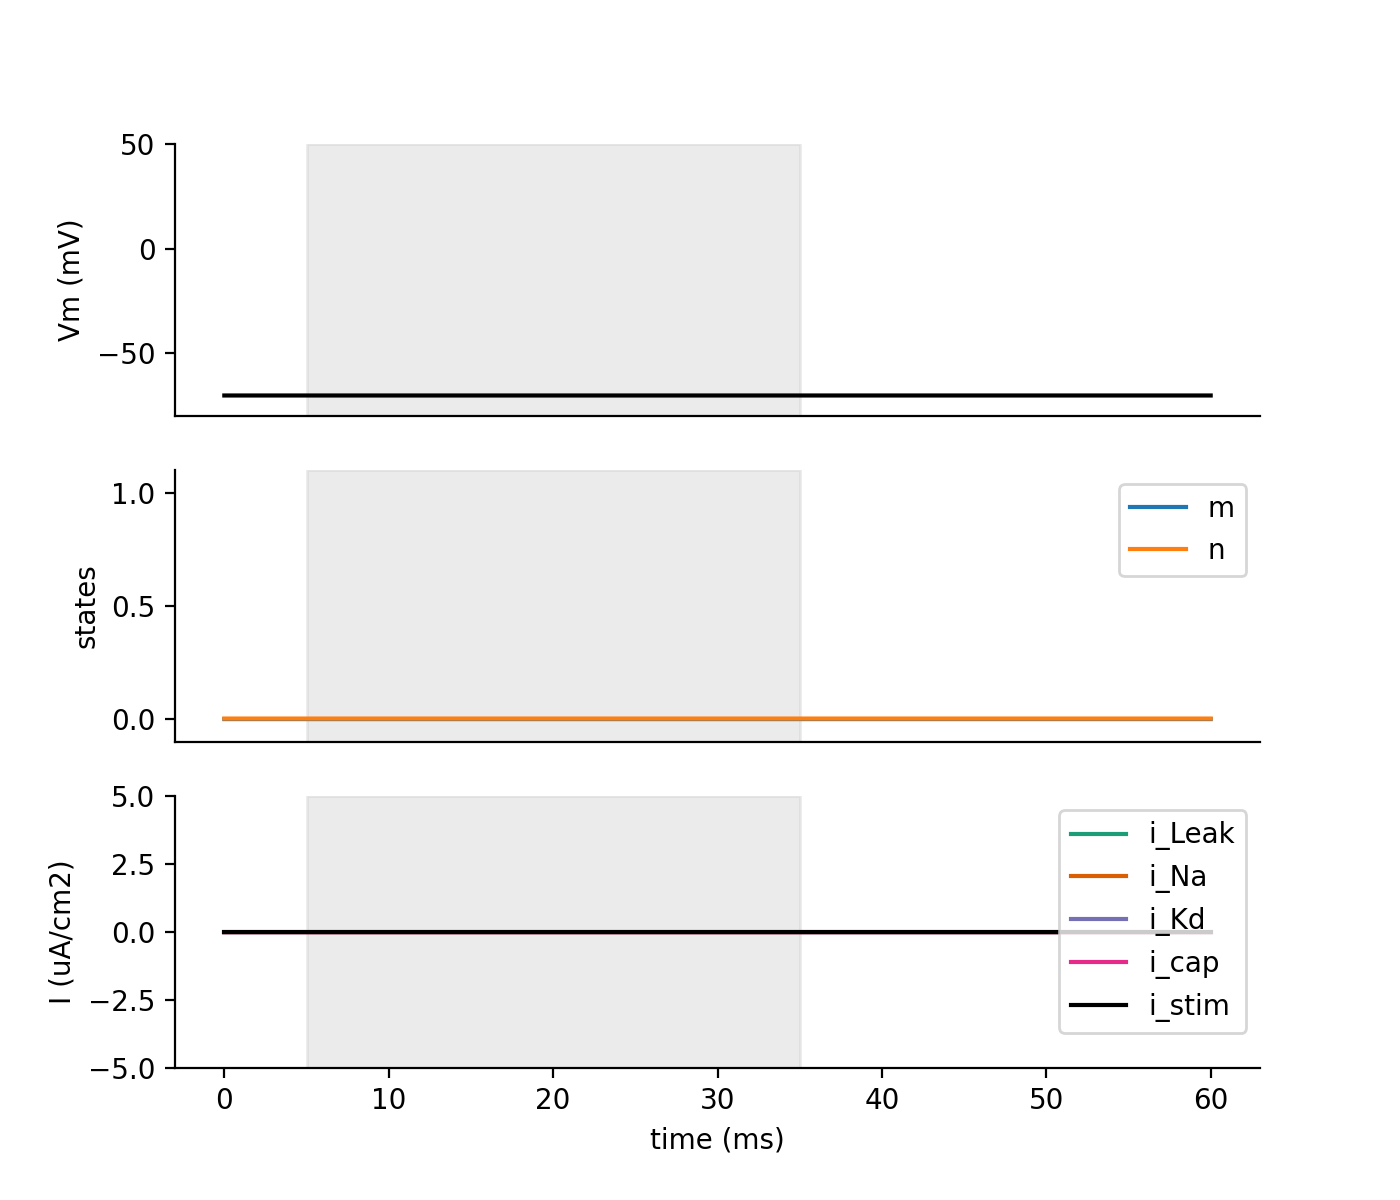

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='I', max=60.0, min=-15.0, st…

In [6]:
EK = -90.0   # Reversal potential (mV)
gKd_bar = 6.0   # Maximal channel conductance (S/cm2)

def alpha_n(Vm):
    return 0.032 * vtrap(15 - (Vm - V_T), 5)  # ms-1

def beta_n(Vm):
    return 0.5 * exp(-((Vm - V_T) - 10) / 40)  # ms-1

def dn_dt(n, Vm):
    return alpha_n(Vm) * (1 - n) - beta_n(Vm) * n  # ms-1

def n_inf(Vm):
    return alpha_n(Vm) / (alpha_n(Vm) + beta_n(Vm))  # (-)

def i_Kd(n, Vm):
    return gKd_bar * n**4 * (Vm - EK)  # uA/cm2

# Update model and run interactive simulation
model.add_current(i_Kd)
model.add_state(dn_dt, n_inf)
interactive_simulation(model.copy());

### Questions
- *As you apply a positive stimulus, do you observe any difference in behavior?*
- *What do you conclude about the role of potassium channels on membrane potential?*
- *Is this membrane configuration enough to elicit multiple "action potentials" (or "spikes")?*

### Step 4: a sodium inactivation gate

While the addition of potassium current offers some counterweight to our sodium current, our membrane still stabilizes around a plateau potential upon stimulation. To finally obtain a so-called "spiking" behavior, we must ensure repolarization. To this aim, let's add a so-called **inactivation gate** (*H*) to our sodium channels.

Our governing equation is therefore slightly modified:

$C_m \frac{dV_m}{dt} = I_{stim} - [I_{Leak}(V_m) + I_{Na}(m, h, V_m) + I_{Kd}(n, V_m)]$

 02/02/2022 16:52:56: simulating model with CurrentPulseTrain(I=0.00uA/cm2, tpulse=30.0ms, npulses=1, PRF=0.10kHz, tstart=5.0ms) stimulus for 60.0 ms...


<IPython.core.display.Javascript object>


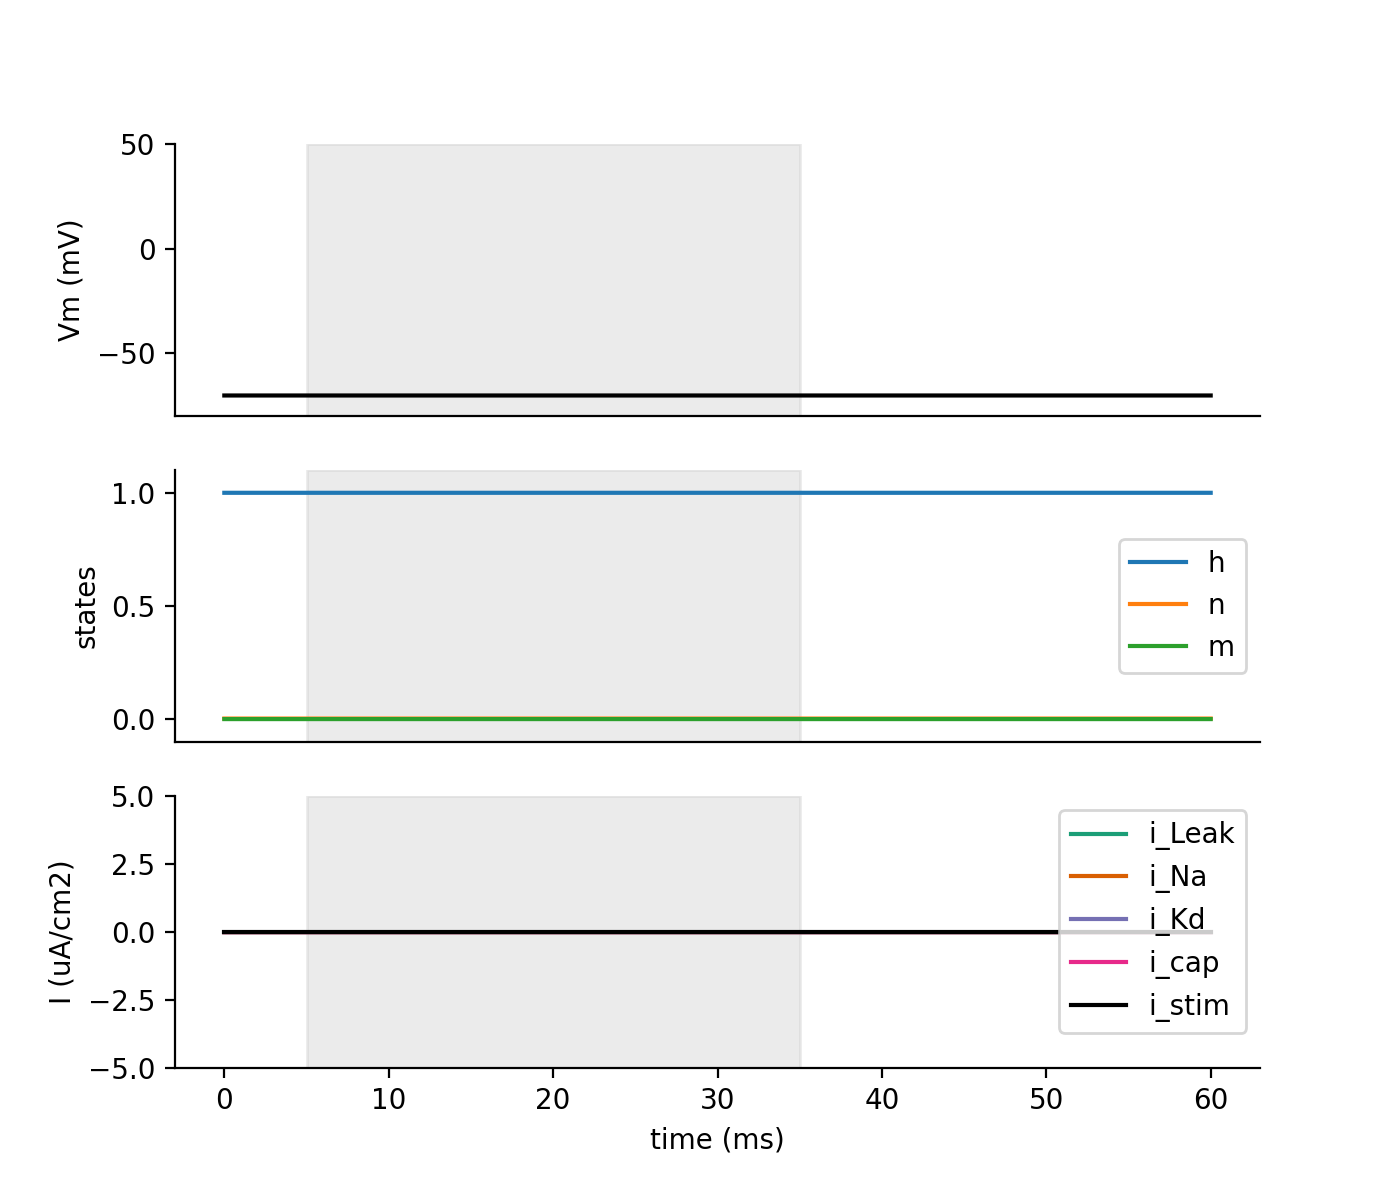

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='I', max=60.0, min=-15.0, st…

In [7]:
def alpha_h(Vm):
    return 0.128 * exp(-((Vm - V_T) - 17) / 18)  # ms-1

def beta_h(Vm):
    return 4 / (1 + exp(-((Vm - V_T) - 40) / 5))  # ms-1

def dh_dt(h, Vm):
    return alpha_h(Vm) * (1 - h) - beta_h(Vm) * h

def h_inf(Vm):
    return alpha_h(Vm) / (alpha_h(Vm) + beta_h(Vm))

def i_Na(m, h, Vm):
    return gNa_bar * m**3 * h * (Vm - ENa)  # uA/cm2

# Update model and run interactive simulation
model.add_state(dh_dt, h_inf)
model.update_current(i_Na)
interactive_simulation(model.copy());

### Questions
- *As you apply a positive stimulus, do you observe any difference in behavior?*
- *What do you conclude about the role of sodium inactivation gates on membrane dynamics?*

## Summary

By the end of this tutorial, you should have developed a clear intuition of the key components involved in the intricate neuronal membrane dynamics. In light of this, *can you describe, in your own words, the different phases of an action potential?*

YOUR DESCRIPTION:

## Bonus question

The above analysis gives us a good intuition of what an action potential looks like electrically from the inside of a cell. But *what about its extracelluar manifestation?* In other words, ***what will an extracellular spike look like?***

YOUR ANSWER